In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Original data set retrieved from here:
# https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

data = pd.read_csv("AirPassengers.csv", 
                      usecols = [1], 
                      engine = "python", 
                      skipfooter = 3)

In [2]:
# Print some data rows.
data.head()

,#Passengers
0,2
1,2
2,0
3,0
4,0


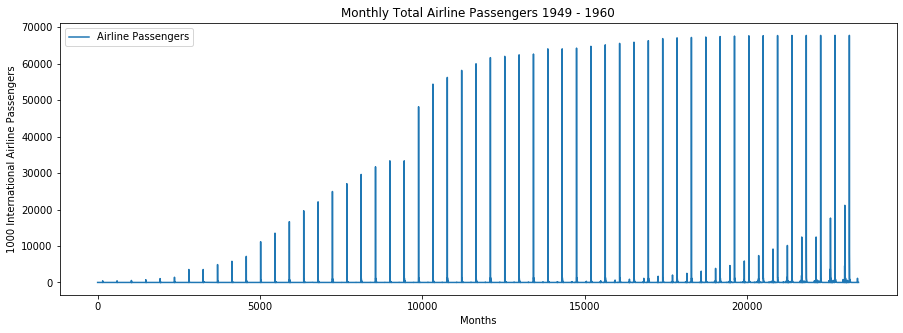

In [3]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

In [4]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

ModuleNotFoundError: No module named 'keras'

In [ ]:
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

In [ ]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

In [ ]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [ ]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

In [ ]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

In [ ]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

In [ ]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()


In [ ]:
SAMPLES = 5000
PERIOD = 50
x = np.linspace(-PERIOD * np.pi, PERIOD * np.pi, SAMPLES)
series = pd.DataFrame(np.sin(x))

plt.figure(figsize = (15, 5))
plt.plot(series.values[:PERIOD])
plt.xlabel("x")
plt.ylabel("y")
plt.title("y = sin(x), first %d samples" % PERIOD)
plt.show()

In [ ]:
# Normalize data on the (-1, 1) interval.
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = scaler.fit_transform(series.values)

# Convert to data frame.
series = pd.DataFrame(scaled)

# Helper function to create a windowed data set.
# FIXME: Copying & overwriting is flawed!
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], 
                            axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

# FIXME: We'll use this only for demonstration purposes.
series_backup = series.copy()
t = create_window(series_backup, 1)
t.head()

In [ ]:
window_size = 50
series = create_window(series, window_size)
print("Shape of input data:")
print(series.shape)

In [ ]:
# Using 80% of data for training, 20% for validation.
# FIXME: Need to align with example 1.
TRAIN_SIZE = 0.80

nrow = round(TRAIN_SIZE * series.shape[0])

train = series.iloc[:nrow, :]
test = series.iloc[nrow:, :]

# Shuffle training data.
train = shuffle(train)

train_X = train.iloc[:, :-1]
test_X = test.iloc[:, :-1]

train_Y = train.iloc[:, -1]
test_Y = test.iloc[:, -1]

print("Training set shape for X (inputs):")
print(train_X.shape)
print("Training set shape for Y (output):")
print(train_Y.shape)

In [ ]:
train_X = np.reshape(train_X.values, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X.values, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(test_X.shape)

In [ ]:
# Define the model.
model2 = Sequential()
model2.add(LSTM(input_shape = (window_size, 1), 
               units = window_size, 
               return_sequences = True))
model2.add(Dropout(0.5))
model2.add(LSTM(256))
model2.add(Dropout(0.5))
model2.add(Dense(1))
model2.add(Activation("linear"))
model2.compile(loss = "mse", 
              optimizer = "adam")
model2.summary()



In [ ]:
# Fit the model.
model2.fit(train_X, 
          train_Y, 
          batch_size = 512,
          epochs = 3,
          validation_split = 0.1)

In [ ]:
# Predict on test data.
pred_test = model2.predict(test_X)

# Apply inverse transformation to get back true values.
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

print("MSE for predicted test set: %2f" % mean_squared_error(test_y_actual, pred_test))

plt.figure(figsize = (15, 5))
plt.plot(test_y_actual, label="True value")
plt.plot(pred_test, label="Predicted value")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Comparison true vs. predicted test set")
plt.legend()
plt.show()